# Social network advertisements: factors and prediction of purchases

This project concerns the construction of a logistic regression model for both examining the factors associated with purchases due to social network adverstisements and the prediction of the probability of the purchases. It is based on a dataset ([obtained through kaggle](https://www.kaggle.com/dragonheir/logistic-regression?select=Social_Network_Ads.csv)) which contains information on whether a purchase has occured as well as the age, estimated salary and gender of the target subjects of the advertisements. It was performed with Anaconda python 3.8.

The first 10 lines of the dataset alongsite with the dtypes pandas has inferred are presented below. I converted the gender variable to a single dummy variable (Male) and searched for missing data of which there were none. I also converted the Age and EstimatedSalary variables to a float64 dtype in order to ensure that later standardizaton of these variables will be unproblematic and I have printed summary statistics for the final variable set.

In [1]:
import numpy as np
from numpy import log
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import patsy

ads = pd.read_csv('Social_Network_Ads.csv',sep=',')

print(ads.head(10))
print('\n')
print(ads.dtypes)
dummy = pd.get_dummies(ads['Gender'],drop_first=True)
ads = pd.concat([ads,dummy],axis=1)
ads.drop(['User ID','Gender'],inplace=True,axis=1)

ads['Age'] = ads['Age'].astype('float64')
ads['EstimatedSalary'] = ads['EstimatedSalary'].astype('float64')

print('\n')
print(ads.isnull().sum())

print('\n')
print(ads.describe())

    User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0
5  15728773    Male   27            58000          0
6  15598044  Female   27            84000          0
7  15694829  Female   32           150000          1
8  15600575    Male   25            33000          0
9  15727311  Female   35            65000          0


User ID             int64
Gender             object
Age                 int64
EstimatedSalary     int64
Purchased           int64
dtype: object


Age                0
EstimatedSalary    0
Purchased          0
Male               0
dtype: int64


              Age  EstimatedSalary   Purchased        Male
count  400.000000       400.000000  400.000000  400.000000
mean    37.655000     69742.500000    0.357500    0.

Next, I plotted histograms of all the variables. There is a discrepancy in the counts of the binary response variable Purchased but not large enough to cause problems. The continuous variables show some deviation from normality but since normality in the predictors is not a requirement for logistic regression this is also unproblematic. No univariate outliers are evident in the graphs.

Text(0.5, 1.0, 'Estimated Salary')

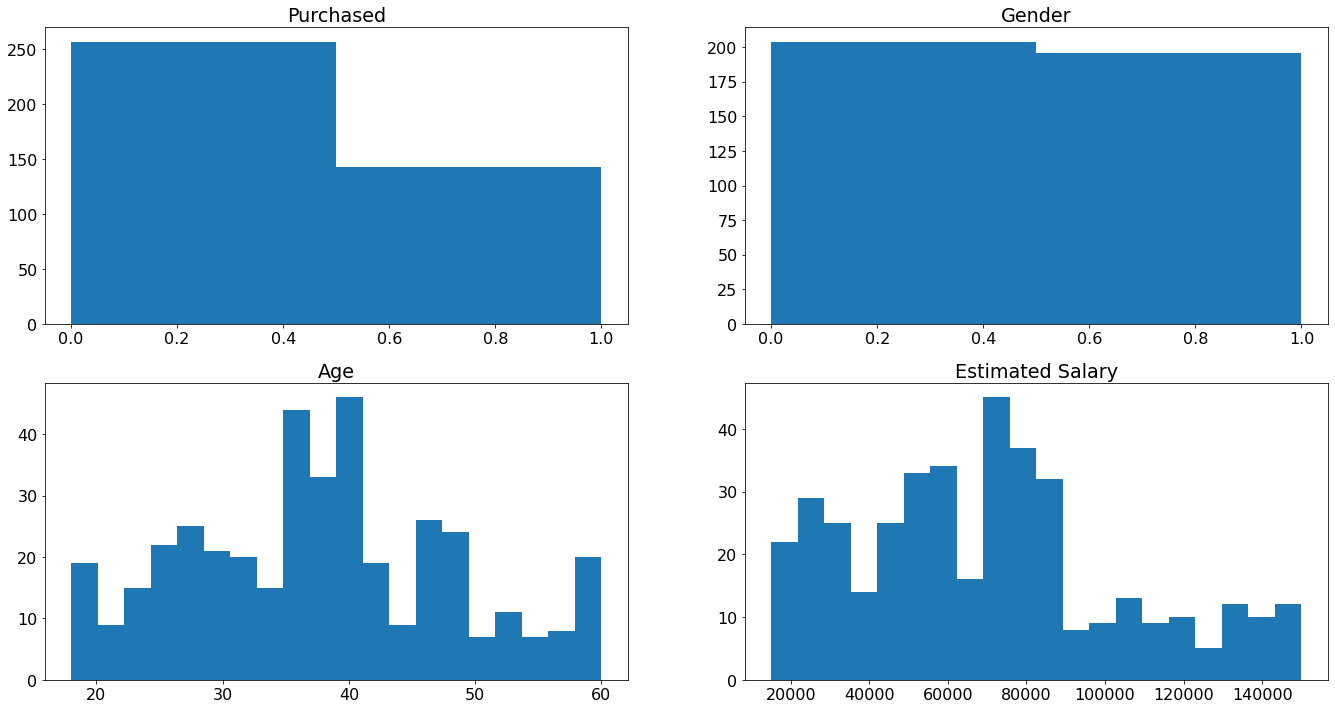

In [2]:
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(2,2,figsize=(23,12))
axs[0,0].hist(ads['Purchased'],bins=2)
axs[0,0].set_title('Purchased')
axs[0,1].hist(ads['Male'],bins=2)
axs[0,1].set_title('Gender')
axs[1,0].hist(ads['Age'],bins=20)
axs[1,0].set_title('Age')
axs[1,1].hist(ads['EstimatedSalary'],bins=20)
axs[1,1].set_title('Estimated Salary')

I then prepared the data for analysis by splitting them into a train set (75% of the data) and a test set (25% of the data).

In [3]:
X = ads.drop('Purchased',axis=1)
y = ads['Purchased']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=1)

train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)

To examine the linearity in the logit assumption I used the Box-Tidwell procedure where the continuous predictors together with the interactions with their natural log transform are being added to a logistic regression model. Significance of the interactions indicates the presence of non-linearity. The correlation between the predictors is low (_r_=0.16) so there is no data collinearity in the model, we cannot center the variables to ensure lack of structural collinearity for the Box-Tidwell since we need positive predictors in order to take the logarithm. We see that the interaction involving the EstimatedSalary is significant, thus I needed to deal with non-linearity for this predictor.

In [4]:
IVcor = pearsonr(train['Age'],train['EstimatedSalary'])
print('Age - EstimatedSalary r:',IVcor[0],'\n')

linLog = sm.Logit.from_formula('Purchased~Age*log(Age)+EstimatedSalary*log(EstimatedSalary)-log(Age)-log(EstimatedSalary)',train).fit()
print(linLog.summary())

Age - EstimatedSalary r: 0.16465213283871974 

Optimization terminated successfully.
         Current function value: 0.255727
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              Purchased   No. Observations:                  300
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            4
Date:                Thu, 21 Jan 2021   Pseudo R-squ.:                  0.5997
Time:                        14:55:08   Log-Likelihood:                -76.718
converged:                       True   LL-Null:                       -191.64
Covariance Type:            nonrobust   LLR p-value:                 1.426e-48
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept

Before running any models I standardized the continuous variables both for coefficient interpretability and in order to reduce mulitcollinearity due to inclusion of powers of variables and interactions. The standardized variables are indicated by the addition of the letter S at the end of the name of the variables.

To begin I examined a model which included the Purchased variable as the response variable, the Male dummy variable, AgeS and EstimatedSalaryS as predictors, with the addition of the square (EstimatedSalarySQ) and cubic power (EstimatedSalaryCB) of EstimatedSalaryS also as predictors as a first attempt to account for the non-linearity issues.

I first present the Variance Inflation Factors for the predictors which indicate no issues with multicollinearity with the possible exception of EstimatedSalaryCB which has a moderate VIF. A look the analysis results reveals that Male is clearly not significant, AgeS, EstimatedSalaryS and EstimatedSalarySQ are significant at an adjusted α of 0.05/6 = 0.008, while EstimatedSalaryCB apporaches but does not reach significance at the adjusted α level. There is also an increase in the log-likelihood of the model compared to the null model which is statistically significant.

In [5]:
train['EstimatedSalaryS'] = 0.0
train['AgeS'] = 0.0
scaler = StandardScaler()
train[['EstimatedSalaryS','AgeS']] = scaler.fit_transform(train[['EstimatedSalary','Age']])
train['EstimatedSalarySQ'] = train['EstimatedSalaryS']**2
train['EstimatedSalaryCB'] = train['EstimatedSalaryS']**3

trainVIF = train.drop(['Purchased','EstimatedSalary','Age'],axis=1)
vifData = pd.DataFrame()
vifData['Regressor'] = trainVIF.columns
vifData['VIF'] = [variance_inflation_factor(trainVIF.values, i) for i in range(len(trainVIF.columns))] 
print('\n',vifData,'\n')

logCB = sm.Logit.from_formula('Purchased~Male+AgeS+EstimatedSalaryS+EstimatedSalarySQ+EstimatedSalaryCB',train).fit()
print(logCB.summary())


            Regressor       VIF
0               Male  1.226226
1   EstimatedSalaryS  5.147031
2               AgeS  1.049678
3  EstimatedSalarySQ  2.975484
4  EstimatedSalaryCB  8.308402 

Optimization terminated successfully.
         Current function value: 0.249090
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Purchased   No. Observations:                  300
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            5
Date:                Thu, 21 Jan 2021   Pseudo R-squ.:                  0.6101
Time:                        14:55:08   Log-Likelihood:                -74.727
converged:                       True   LL-Null:                       -191.64
Covariance Type:            nonrobust   LLR p-value:                 1.619e-48
                        coef    std err          z      P>|z|      [0.025   

Next, I ran a model which included all the previous predictors except for EstimatedSalaryCB. This time there are no issues at all with multicollinearity and all predictors are significant with the exception of Male. Once again there is an increase in the log-likehood compared to the null model which is significant. This model is already quite satisfactory.

In [6]:
trainVIF = train.drop(['Purchased','EstimatedSalary','Age','EstimatedSalaryCB'],axis=1)
vifData = pd.DataFrame()
vifData['Regressor'] = trainVIF.columns
vifData['VIF'] = [variance_inflation_factor(trainVIF.values, i) for i in range(len(trainVIF.columns))] 
print('\n',vifData,'\n')

logSQ = sm.Logit.from_formula('Purchased~Male+AgeS+EstimatedSalaryS+EstimatedSalarySQ',train).fit()
print(logSQ.summary())


            Regressor       VIF
0               Male  1.194804
1   EstimatedSalaryS  1.190361
2               AgeS  1.043320
3  EstimatedSalarySQ  1.362522 

Optimization terminated successfully.
         Current function value: 0.255006
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Purchased   No. Observations:                  300
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            4
Date:                Thu, 21 Jan 2021   Pseudo R-squ.:                  0.6008
Time:                        14:55:08   Log-Likelihood:                -76.502
converged:                       True   LL-Null:                       -191.64
Covariance Type:            nonrobust   LLR p-value:                 1.151e-48
                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------

For the final model I added the interaction term between AgeS and EstimatedSalaryS to the previous model. With the exception of Male all predictors and the interaction are significant at an adjusted α of 0.008. AgeS has a positive association with the odds of purchasing a product. The same is true for the estimated salary predictors but the EstimatedSalaryS coefficient now represents the variable's effect at the mean age with the siginificant interaction indicating that age moderates the effect of estimated salary on the odds of purchasing an advertisement product. There is also a futher increase in the model log-likelihood compared to the previous model.

In [7]:
logSQInteractions = sm.Logit.from_formula('Purchased~Male+AgeS*EstimatedSalaryS+EstimatedSalarySQ',train).fit()
print(logSQInteractions.summary())

Optimization terminated successfully.
         Current function value: 0.229926
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              Purchased   No. Observations:                  300
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            5
Date:                Thu, 21 Jan 2021   Pseudo R-squ.:                  0.6401
Time:                        14:55:08   Log-Likelihood:                -68.978
converged:                       True   LL-Null:                       -191.64
Covariance Type:            nonrobust   LLR p-value:                 5.536e-51
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.1749      0.503     -6.311      0.000      -4.161      -2.

I also examined the Pearson residuals for possible outliers in the solution. Below is presented a plot of the residuals as well as a print-out of all the residuals with an absolute value greater than 2. No abnormarlities were found in the values for these latter cases so they were retained.

     Pearson_res  Male   Age  EstimatedSalary  Purchased
146     3.159367     0  27.0          96000.0          1
    Pearson_res  Male   Age  EstimatedSalary  Purchased
91    -2.128627     0  30.0         116000.0          0
    Pearson_res  Male   Age  EstimatedSalary  Purchased
59    -2.415812     0  32.0         117000.0          0
     Pearson_res  Male   Age  EstimatedSalary  Purchased
358      2.07701     1  40.0          71000.0          1
     Pearson_res  Male   Age  EstimatedSalary  Purchased
303      2.35042     1  37.0          79000.0          1
     Pearson_res  Male   Age  EstimatedSalary  Purchased
212    -13.95162     0  59.0          42000.0          0
     Pearson_res  Male   Age  EstimatedSalary  Purchased
315     3.172638     0  39.0          75000.0          1
     Pearson_res  Male   Age  EstimatedSalary  Purchased
306    -7.404158     0  51.0         134000.0          0
     Pearson_res  Male   Age  EstimatedSalary  Purchased
282     3.235942     1  37.0       

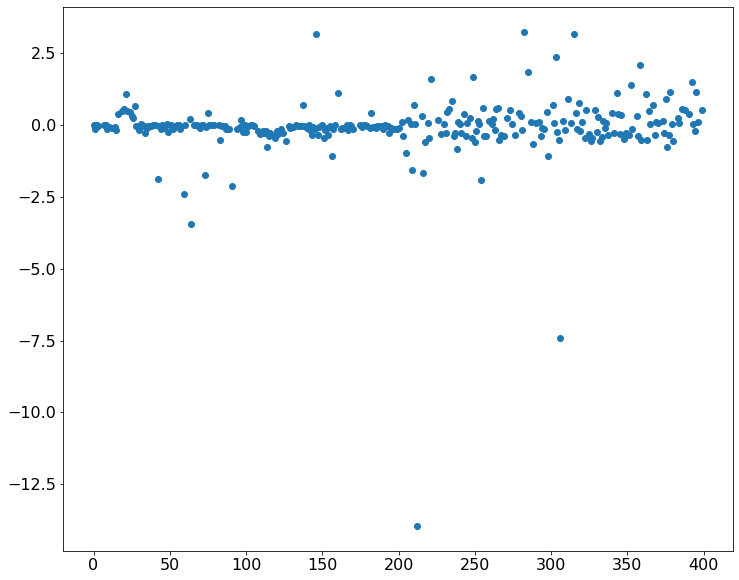

In [8]:
plt.figure(figsize=(12,10))
plt.scatter(train.index,logSQInteractions.resid_pearson)
train['Pearson_res'] = logSQInteractions.resid_pearson
outliers = logSQInteractions.resid_pearson[np.abs(logSQInteractions.resid_pearson)>2].index
for i in outliers:
    printout = train[train.index==i]
    print(printout[['Pearson_res','Male','Age','EstimatedSalary','Purchased']])

Finally I will examine the predictive performance of my final model, using the test data, by means of a confusion matrix and a ROC curve. To produce these I will use scikit learn with which I will fit the equation for the interaction model once again. The results are presented below, the model has successfully categorized 88% ((49+39)/100 = 0.88) of the test data and the area under the ROC curve (0.89) is very high with both measures indicating the predictive value of the model.

[[49  9]
 [ 3 39]]


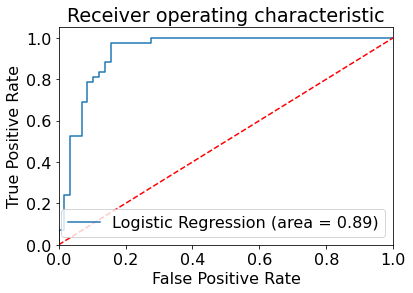

In [9]:
test['EstimatedSalaryS'] = 0.0
test['AgeS'] = 0.0
test[['EstimatedSalaryS','AgeS']] = scaler.transform(test[['EstimatedSalary','Age']])
test['EstimatedSalarySQ'] = test['EstimatedSalaryS']**2

f = 'Purchased~Male+AgeS*EstimatedSalaryS+EstimatedSalarySQ'
y_train,X_train = patsy.dmatrices(f,train,return_type='dataframe')
y_test,X_test = patsy.dmatrices(f,test,return_type='dataframe')

logReg = LogisticRegression(penalty="none",fit_intercept=False)
logReg.fit(X_train,y_train.values.ravel())

y_pred = logReg.predict(X_test)
confusionMatrix = confusion_matrix(y_test,y_pred)
print(confusionMatrix)

logit_roc_auc = roc_auc_score(y_test,logReg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test,logReg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()